In [1]:
# general imports
import sys
import os
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import time
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier

In [4]:
from src.dgd.latent import RepresentationLayer
from src.dgd.latent import GaussianMixture
from src.dgd.nn import NB_Module
from src.utils.helpers import set_seed
from src.model.decoder import Decoder
from src.data.flat_dataset import FlattenedDataset

from src.test.onehot_mut_predict import prepare_potential_reps # changed
from src.test.onehot_mut_predict import learn_new_representation # changed

In [5]:
print(torch.__version__)

2.4.1+cu121


In [6]:
# set random seeds, device and data directory
seed = 1 
set_seed(seed)
num_workers = 8 # add to the data loaders
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") # add gpu to node request

In [7]:
print("GPU name:", torch.cuda.get_device_name(torch.cuda.current_device()) if torch.cuda.is_available() else "No GPU")

GPU name: NVIDIA L40S


In [ ]:
# set directory for output files
os.chdir('/path/to...')

In [9]:
# Read data, only HMF
# mut_data = pd.read_csv("SNV_mutation_catalogue_HMF.tsv", sep='\t')

In [10]:
# mut_data = mut_data.iloc[:, 3:] # from column index 3

In [11]:
# we want the data including the tissue type. The "i" column is the original index (a few samples are removed as they werent compatible in the ID)
# mut_data = pd.read_csv("to_dgd.tsv", sep='\t') # 11.08 on GPU 128g and 16 cores
# > 30 min with 500g and 16 cores CPU

In [12]:
#import pyarrow.csv as pv

#table = pv.read_csv("to_dgd.tsv", parse_options=pv.ParseOptions(delimiter="\t"))
#mut_data = table.to_pandas()

In [13]:
#mut_data = pd.read_csv("to_dgd.tsv", sep='\t', engine="pyarrow")

In [14]:
mut_data = pd.read_parquet("to_dgd.parquet") # 15 sec on CPU

In [15]:
mut_data

,AA[C>A]AA,AA[C>A]AC,AA[C>A]AG,AA[C>A]AT,AA[C>A]CA,AA[C>A]CC,AA[C>A]CG,AA[C>A]CT,AA[C>A]GA,AA[C>A]GC,...,TT[T>G]CT,TT[T>G]GA,TT[T>G]GC,TT[T>G]GG,TT[T>G]GT,TT[T>G]TA,TT[T>G]TC,TT[T>G]TG,TT[T>G]TT,Tumor_Type
Donor_ID,,,,,,,,,,,,,,,,,,,,,
DO1001,12,6,5,11,7,4,2,6,2,0,...,2,7,4,5,7,12,5,3,13,Breast-AdenoCa
DO1002,20,4,6,5,11,9,0,4,3,2,...,3,4,0,6,6,6,1,2,7,Breast-AdenoCa
DO1003,13,4,7,6,3,6,0,9,2,0,...,2,6,3,1,6,5,3,3,8,Breast-AdenoCa
DO1004,34,11,19,24,33,13,3,20,2,1,...,11,9,7,10,12,5,7,6,17,Breast-AdenoCa
DO1005,9,5,5,7,9,10,3,9,0,0,...,3,3,3,2,3,5,4,2,4,Breast-AdenoCa
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
DO9700,51,14,40,43,47,17,2,29,4,0,...,4,19,7,14,13,47,27,13,80,ColoRect-AdenoCA
DO9732,76,21,24,47,39,28,0,22,5,3,...,5,9,6,14,15,17,27,12,48,ColoRect-AdenoCA
DO9788,59,10,25,26,26,16,2,20,7,2,...,4,14,6,7,13,39,27,18,65,ColoRect-AdenoCA


In [16]:
# no NaNs
mut_data.isna().sum().sum()

np.int64(0)

In [17]:
#subsample = mut_data.sample(n=500)

In [18]:
# split into train and val/test data
train_data, val_test_data = train_test_split(mut_data, test_size=0.30, random_state=seed, stratify=mut_data['Tumor_Type'])

In [19]:
train_data

,AA[C>A]AA,AA[C>A]AC,AA[C>A]AG,AA[C>A]AT,AA[C>A]CA,AA[C>A]CC,AA[C>A]CG,AA[C>A]CT,AA[C>A]GA,AA[C>A]GC,...,TT[T>G]CT,TT[T>G]GA,TT[T>G]GC,TT[T>G]GG,TT[T>G]GT,TT[T>G]TA,TT[T>G]TC,TT[T>G]TG,TT[T>G]TT,Tumor_Type
Donor_ID,,,,,,,,,,,,,,,,,,,,,
DO50420,21,8,7,10,14,4,2,10,2,0,...,2,2,0,2,2,3,4,3,12,Prost-AdenoCA
DO52701,8,3,4,6,5,5,0,5,0,0,...,4,2,0,1,5,10,9,2,27,Lymph-CLL
DO51500,23,4,5,9,17,7,1,1,1,0,...,3,2,0,4,1,9,7,2,14,Panc-AdenoCA
DO10829,3,3,3,1,5,1,0,2,0,1,...,0,0,0,1,1,0,1,0,3,Prost-AdenoCA
DO51069,10,3,4,5,4,5,0,1,0,0,...,2,1,0,0,2,2,1,0,6,Prost-AdenoCA
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
DO45239,19,10,8,9,15,5,0,5,2,2,...,1,3,1,0,4,3,4,2,10,Liver-HCC
DO6474,5,3,4,1,0,0,0,3,1,0,...,0,0,0,2,2,0,0,1,3,Lymph-CLL
DO48952,1,0,0,2,0,1,1,1,0,0,...,0,3,1,0,1,0,0,1,2,CNS-Medullo


In [20]:
label_counts = train_data['Tumor_Type'].value_counts()
len(label_counts)

27

In [21]:
counts = train_data['Tumor_Type'].value_counts()
counts # 27 tumor types

Tumor_Type
Liver-HCC           220
Panc-AdenoCA        162
Prost-AdenoCA       139
Breast-AdenoCa      136
Kidney-RCC          100
CNS-Medullo          99
Ovary-AdenoCA        77
Skin-Melanoma        75
Lymph-BNHL           73
Eso-AdenoCa          68
Lymph-CLL            63
CNS-PiloAstro        62
Panc-Endocrine       57
Stomach-AdenoCA      48
Head-SCC             39
ColoRect-AdenoCA     36
Thy-AdenoCA          34
Lung-SCC             33
Uterus-AdenoCA       31
Kidney-ChRCC         30
Bone-Osteosarc       29
CNS-GBM              27
Lung-AdenoCA         26
Biliary-AdenoCA      24
Bone-Leiomyo         24
Myeloid-MPN          16
Bladder-TCC          16
Name: count, dtype: int64

In [22]:
# remove those types with under 2 samples
#val_test_data = val_test_data[~val_test_data["Tumor_Type"].isin(["Myeloid-MPN", "Bladder-TCC", "ColoRect-AdenoCA"])]

In [23]:
counts = val_test_data['Tumor_Type'].value_counts()
counts # 27 tumor types

Tumor_Type
Liver-HCC           94
Panc-AdenoCA        70
Prost-AdenoCA       60
Breast-AdenoCa      59
Kidney-RCC          43
CNS-Medullo         42
Ovary-AdenoCA       33
Lymph-BNHL          32
Skin-Melanoma       32
Eso-AdenoCa         29
Lymph-CLL           27
CNS-PiloAstro       27
Panc-Endocrine      24
Stomach-AdenoCA     20
Head-SCC            17
ColoRect-AdenoCA    16
Thy-AdenoCA         14
Lung-SCC            14
Uterus-AdenoCA      13
Kidney-ChRCC        13
Bone-Osteosarc      12
CNS-GBM             12
Lung-AdenoCA        11
Biliary-AdenoCA     10
Bone-Leiomyo        10
Bladder-TCC          7
Myeloid-MPN          7
Name: count, dtype: int64

In [24]:
validation_data, test_data = train_test_split(val_test_data, test_size=0.5, random_state=seed, stratify=val_test_data['Tumor_Type'])

In [25]:
validation_data

,AA[C>A]AA,AA[C>A]AC,AA[C>A]AG,AA[C>A]AT,AA[C>A]CA,AA[C>A]CC,AA[C>A]CG,AA[C>A]CT,AA[C>A]GA,AA[C>A]GC,...,TT[T>G]CT,TT[T>G]GA,TT[T>G]GC,TT[T>G]GG,TT[T>G]GT,TT[T>G]TA,TT[T>G]TC,TT[T>G]TG,TT[T>G]TT,Tumor_Type
Donor_ID,,,,,,,,,,,,,,,,,,,,,
DO50837,9,3,4,3,3,4,1,2,0,0,...,1,0,1,0,0,1,0,0,7,Liver-HCC
DO9074,80,18,43,52,36,30,3,14,2,0,...,2,2,1,6,2,9,5,2,35,ColoRect-AdenoCA
DO15398,53,14,17,32,26,18,0,10,2,0,...,5,13,3,5,10,15,4,15,36,Head-SCC
DO46744,5,1,2,0,2,2,0,0,0,0,...,0,0,0,0,1,1,2,0,4,Panc-Endocrine
DO49768,15,2,2,7,7,3,0,7,1,1,...,9,0,3,0,6,12,6,2,28,Kidney-RCC
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
DO46328,14,1,7,7,13,5,2,7,0,0,...,3,3,2,3,3,4,5,5,17,Ovary-AdenoCA
DO23028,38,16,26,19,26,14,3,32,4,6,...,6,3,3,4,2,7,7,7,14,Liver-HCC
DO48925,2,0,0,2,1,1,0,0,0,0,...,0,1,0,0,1,0,0,0,1,CNS-Medullo


In [26]:
#validation_data = validation_data.sample(frac=0.1, random_state=1, replace=False)

In [27]:
test_data

,AA[C>A]AA,AA[C>A]AC,AA[C>A]AG,AA[C>A]AT,AA[C>A]CA,AA[C>A]CC,AA[C>A]CG,AA[C>A]CT,AA[C>A]GA,AA[C>A]GC,...,TT[T>G]CT,TT[T>G]GA,TT[T>G]GC,TT[T>G]GG,TT[T>G]GT,TT[T>G]TA,TT[T>G]TC,TT[T>G]TG,TT[T>G]TT,Tumor_Type
Donor_ID,,,,,,,,,,,,,,,,,,,,,
DO51074,14,3,4,5,8,6,0,5,0,0,...,3,0,1,2,0,0,2,0,8,Prost-AdenoCA
DO51496,14,3,8,11,11,5,0,7,1,1,...,2,2,0,1,1,2,2,2,9,Panc-AdenoCA
DO15046,81,38,65,75,49,33,7,41,7,5,...,8,10,14,7,8,13,20,11,64,Head-SCC
DO6558,7,2,0,3,2,0,1,0,2,0,...,0,0,1,0,1,0,0,1,3,Lymph-CLL
DO50410,48,10,38,27,38,22,1,22,4,1,...,7,16,3,8,7,171,92,78,143,Eso-AdenoCa
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
DO46400,42,18,21,19,31,15,4,32,4,2,...,2,10,6,13,6,7,2,8,18,Ovary-AdenoCA
DO51514,13,8,11,10,7,10,0,7,1,0,...,0,3,0,8,4,9,6,8,25,Panc-AdenoCA
DO51144,16,2,6,3,10,4,0,8,0,0,...,0,2,0,0,0,2,3,1,10,Prost-AdenoCA


In [28]:
train_data.iloc[0]

AA[C>A]AA                21
AA[C>A]AC                 8
AA[C>A]AG                 7
AA[C>A]AT                10
AA[C>A]CA                14
                  ...      
TT[T>G]TA                 3
TT[T>G]TC                 4
TT[T>G]TG                 3
TT[T>G]TT                12
Tumor_Type    Prost-AdenoCA
Name: DO50420, Length: 1537, dtype: object

In [29]:
# dimensions for features
out_dim = 1

In [30]:
# I'll call it validation loader for now
# train_ratio = 0.9
# train_data = train_val_data .iloc[:int(train_ratio*len(train_val_data )),:]
# validation_data = train_val_data .iloc[int(train_ratio*len(train_val_data )):,:]

#train_data, validation_data = train_test_split(train_val_data, test_size=0.1, random_state=seed, stratify=train_val_data[primaryTumorLocation])

# define scaling for NB
# each sample gets a scaling factor
# scaling factors already built in in Dataset
# scaling_factors = torch.mean(torch.Tensor(train_data.iloc[:,:-1].to_numpy()), dim=-1).unsqueeze(1)
# validation_scaling_factors = torch.mean(torch.Tensor(validation_data.iloc[:,:-1].to_numpy()), dim=-1).unsqueeze(1)
# make data loaders
train_loader = torch.utils.data.DataLoader(FlattenedDataset(train_data, scaling_type="mean"),  # num_workers=num_workers
                                          batch_size=1536,
                                          shuffle=True)
validation_loader = torch.utils.data.DataLoader(FlattenedDataset(validation_data, scaling_type="mean"),
                                          batch_size=1536,
                                          shuffle=False)

# The class GeneExpressionDataset also works for samples x mut_type (row x column)

In [31]:
#train_loader.dataset.mut_matrix

In [32]:
len(train_loader.dataset.labels)

1744

In [33]:
1744*1537

2680528

In [34]:
# batches
len(train_loader)

1744

In [35]:
train_data

,AA[C>A]AA,AA[C>A]AC,AA[C>A]AG,AA[C>A]AT,AA[C>A]CA,AA[C>A]CC,AA[C>A]CG,AA[C>A]CT,AA[C>A]GA,AA[C>A]GC,...,TT[T>G]CT,TT[T>G]GA,TT[T>G]GC,TT[T>G]GG,TT[T>G]GT,TT[T>G]TA,TT[T>G]TC,TT[T>G]TG,TT[T>G]TT,Tumor_Type
Donor_ID,,,,,,,,,,,,,,,,,,,,,
DO50420,21,8,7,10,14,4,2,10,2,0,...,2,2,0,2,2,3,4,3,12,Prost-AdenoCA
DO52701,8,3,4,6,5,5,0,5,0,0,...,4,2,0,1,5,10,9,2,27,Lymph-CLL
DO51500,23,4,5,9,17,7,1,1,1,0,...,3,2,0,4,1,9,7,2,14,Panc-AdenoCA
DO10829,3,3,3,1,5,1,0,2,0,1,...,0,0,0,1,1,0,1,0,3,Prost-AdenoCA
DO51069,10,3,4,5,4,5,0,1,0,0,...,2,1,0,0,2,2,1,0,6,Prost-AdenoCA
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
DO45239,19,10,8,9,15,5,0,5,2,2,...,1,3,1,0,4,3,4,2,10,Liver-HCC
DO6474,5,3,4,1,0,0,0,3,1,0,...,0,0,0,2,2,0,0,1,3,Lymph-CLL
DO48952,1,0,0,2,0,1,1,1,0,0,...,0,3,1,0,1,0,0,1,2,CNS-Medullo


In [36]:
#all_values = train_loader.dataset.mut_matrix.flatten()
#all_values

In [37]:
i = 0
for value, lib, sample_idx, mut_idx, onehot in validation_loader:
    print(sample_idx, mut_idx)
    print(onehot)
    i = i+1
    if i == 10:
        break

tensor([0, 0, 0,  ..., 0, 0, 0]) tensor([   0,    1,    2,  ..., 1533, 1534, 1535])
tensor([[1., 0., 0.,  ..., 0., 0., 0.],
        [1., 0., 0.,  ..., 1., 0., 0.],
        [1., 0., 0.,  ..., 0., 1., 0.],
        ...,
        [0., 0., 0.,  ..., 1., 0., 0.],
        [0., 0., 0.,  ..., 0., 1., 0.],
        [0., 0., 0.,  ..., 0., 0., 1.]])
tensor([1, 1, 1,  ..., 1, 1, 1]) tensor([   0,    1,    2,  ..., 1533, 1534, 1535])
tensor([[1., 0., 0.,  ..., 0., 0., 0.],
        [1., 0., 0.,  ..., 1., 0., 0.],
        [1., 0., 0.,  ..., 0., 1., 0.],
        ...,
        [0., 0., 0.,  ..., 1., 0., 0.],
        [0., 0., 0.,  ..., 0., 1., 0.],
        [0., 0., 0.,  ..., 0., 0., 1.]])
tensor([2, 2, 2,  ..., 2, 2, 2]) tensor([   0,    1,    2,  ..., 1533, 1534, 1535])
tensor([[1., 0., 0.,  ..., 0., 0., 0.],
        [1., 0., 0.,  ..., 1., 0., 0.],
        [1., 0., 0.,  ..., 0., 1., 0.],
        ...,
        [0., 0., 0.,  ..., 1., 0., 0.],
        [0., 0., 0.,  ..., 0., 1., 0.],
        [0., 0., 0.,  ..., 

In [38]:
#all_values.shape

In [39]:
n_tissues = len(mut_data["Tumor_Type"].unique())
n_tissues

27

In [40]:
# hyperparameters
latent_dim = 20
decoder_latent_dim = 64 # double latent_dim as the two reps are concatenated, 24 onehot vectors
hidden_dims = [100, 100, 100]
reduction_type = "mean" # output loss reduction

In [41]:
# decoder setup

# set up an output module for the mutation data
gex_out_fc = nn.Sequential(
    nn.Linear(hidden_dims[-1], out_dim) # input and output (mutation counts) for the last layer
    )
output_gex_layer = NB_Module(gex_out_fc, out_dim, scaling_type="mean") # negative binomial of final output
output_gex_layer.n_features = out_dim

# set up the decoder
decoder = Decoder(decoder_latent_dim, hidden_dims, [output_gex_layer]).to(device)

In [42]:
palette = {
    "Biliary-AdenoCA": "#00CD66",
    "Bladder-TCC": "turquoise",
    "Bone-Epith": "#ADAC44",
    "Bone-Leiomyo": "green", # I added
    "Bone-Osteosarc": "#FFD700",
    "Breast-AdenoCa": "#CD6090",
    "CNS-GBM": "#3D3D3D",
    "CNS-Medullo": "#D8BFD8",
    "CNS-Oligo": "#787878",
    "CNS-PiloAstro": "#B0B0B0",
    "Cervix-SCC": "#79CDCD",
    "ColoRect-AdenoCA": "#191970",
    "Eso-AdenoCa": "#1E90FF",
    "Head-SCC": "#8B2323",
    "Kidney-ChRCC": "#B32F0B",
    "Kidney-RCC": "#FF4500",
    "Liver-HCC": "#006400",
    "Lung-AdenoCA": "pink",
    "Lung-SCC": "#FDF5E6",
    "Lymph-BNHL": "#698B22",
    "Lymph-CLL": "#F4A35D", # found the right one
    "Myeloid-AML": "#CD6600",
    "Myeloid-MPN": "#FFC100",
    "Ovary-AdenoCA": "#008B8B",
    "Panc-AdenoCA": "#7A378B",
    "Panc-Endocrine": "#E066FF",
    "Prost-AdenoCA": "#87CEFA",
    "Skin-Melanoma": "#000000",
    "SoftTissue-Leiomyo": "#FFEC8B",
    "SoftTissue-Liposarc": "#CDCB50",
    "Stomach-AdenoCA": "#BFEFFF",
    "Thy-AdenoCA": "#9370DB",
    "Uterus-AdenoCA": "#FF8C69"
}

In [43]:
# combine everything in one class (if desired)

class DGD(nn.Module):
    def __init__(self,decoder,n_mix,mut_n_mix,rep_dim,mut_rep_dim,gmm_spec={},mut_gmm_spec={}):
        super(DGD, self).__init__()
        self.decoder=decoder
        self.rep_dim=rep_dim      # Dimension of representation
        self.mut_rep_dim=mut_rep_dim  
        
        self.gmm=GaussianMixture(n_mix,rep_dim,**gmm_spec)
        self.train_rep=None
        self.val_rep=None
        self.test_rep=None

        # Added for mutation representation
        self.mut_gmm=GaussianMixture(mut_n_mix,mut_rep_dim,**mut_gmm_spec)
        self.mut_train_rep=None
        self.mut_val_rep=None
        self.mut_test_rep=None

    def forward(self,z,mut_z,onehot):
        # Concatenate sample and mutation representations
        combined_z = torch.cat((z, mut_z, onehot), dim=1)
        return self.decoder(combined_z)

    def loss(self,combined_z,z,mut_z,y,target,scale,gmm_loss=True,mut_gmm_loss=True,reduction="mean"):
        self.dec_loss = self.decoder.loss(y,target,scale=scale,mod_id=None,feature_ids=None,reduction=reduction) # add key for scale and the rest, not necessary before adding mut rep, why?
        if gmm_loss:
            self.gmm_loss = self.gmm(z)
            self.mut_gmm_loss = self.mut_gmm(mut_z)
            if reduction=="mean":
                self.gmm_loss = self.gmm_loss.mean()
                self.mut_gmm_loss = self.mut_gmm_loss.mean()
            elif reduction=="sum":
                self.gmm_loss = self.gmm_loss.sum()
                self.mut_gmm_loss = self.mut_gmm_loss.sum()
            return self.dec_loss, self.gmm_loss, self.mut_gmm_loss
        else:
            return self.dec_loss, None, None
    
    def forward_and_loss(self,z,mut_z,onehot,target,scale,gmm_loss=True,mut_gmm_loss=True,reduction="mean"):
        combined_z = torch.cat((z, mut_z, onehot), dim=1)
        y = self.decoder(combined_z) # decoder output
        return self.loss(combined_z,z,mut_z,y,target,scale,gmm_loss,mut_gmm_loss,reduction) # Outputs the decoder reconstruction loss and both gmm losses.
    
    def get_representations(self, rep_type="sample", type="train"):   # The one I use. Detached from the computation graph. Added rep_type.
        if rep_type == "sample":
            if type == "train":
                return self.train_rep.z.detach().cpu().numpy()
            elif type == "val":
                return self.val_rep.z.detach().cpu().numpy()
            elif type == "test":
                return self.test_rep.z.detach().cpu().numpy()
        if rep_type == "mutation":
            if type == "train":
                return self.mut_train_rep.mut_z.detach().cpu().numpy()
            elif type == "val":
                return self.mut_val_rep.mut_z.detach().cpu().numpy()
            elif type == "test":
                return self.mut_test_rep.mut_z.detach().cpu().numpy()
        
    def get_gmm_means(self, rep_type="sample"): # Added rep_type
        if rep_type == "sample":
            return self.gmm.mean.detach().cpu().numpy()
        if rep_type == "mutation":
            return self.mut_gmm.mean.detach().cpu().numpy()
    
    def get_latent_space_values(self, rep_type="sample", type="train", n_samples=1000): # Cloned and isolated from the original tensors. Added rep_type.
        # get representations    
        if rep_type == "sample":
            if type=="train":
                rep = self.train_rep.z.clone().detach().cpu().numpy()
            elif type=="val":
                rep = self.val_rep.z.clone().detach().cpu().numpy()
            elif type=="test":
                rep = self.test_rep.z.clone().detach().cpu().numpy()
            
            # get gmm means
            gmm_means = self.gmm.mean.clone().detach().cpu().numpy()
    
            # get some gmm samples
            gmm_samples = self.gmm.sample(n_samples).detach().cpu().numpy()
            
        if rep_type == "mutation":
            if type=="train":
                rep = self.mut_train_rep.z.clone().detach().cpu().numpy() # mut_z or z? just z
            elif type=="val":
                rep = self.mut_val_rep.z.clone().detach().cpu().numpy()
            elif type=="test":
                rep = self.mut_test_rep.z.clone().detach().cpu().numpy()
            
            # get gmm means
            gmm_means = self.mut_gmm.mean.clone().detach().cpu().numpy()
    
            # get some gmm samples
            gmm_samples = self.mut_gmm.sample(n_samples).detach().cpu().numpy()
    
        return rep, gmm_means, gmm_samples # should I change to separate names for each rep_type? No

In [44]:
import torch
print(torch.cuda.get_device_name(0))
print(torch.cuda.get_device_properties(0).total_memory / 1024**3, "GB")

NVIDIA L40S
44.40283203125 GB


In [45]:
# write a minimal training function

def train_dgd(dgd, train_data, validation_loader, device, learning_rates={'dec':0.001,'rep':0.01,'gmm':0.01},weight_decay=0.,nepochs=100,pr=1,plot=10,reduction_type="mean"):
    if reduction_type == "mean": 
        tlen=len(train_loader.dataset) # Now no dgd.decoder.n_out_features as there is only one output for the NB, so only one recon loss pr input.
        tlen_gmm=len(train_loader.dataset)*dgd.gmm.n_mix_comp*dgd.gmm.dim
        vlen=len(validation_loader.dataset)
        vlen_gmm=len(validation_loader.dataset)*dgd.gmm.n_mix_comp*dgd.gmm.dim
        
    else: # should also be changed as above
        tlen=len(train_loader)
        tlen_gmm=len(train_loader)
        vlen=len(validation_loader)
        vlen_gmm=len(validation_loader)

    # initialize representations
    Ntrain=train_loader.dataset.num_samples
    if dgd.train_rep is None:
        dgd.train_rep = RepresentationLayer(dgd.rep_dim,Ntrain).to(device) # changed bc of the new flattened dataset format
    Nvalidation=validation_loader.dataset.num_samples
    if dgd.val_rep is None:
        dgd.val_rep = RepresentationLayer(dgd.rep_dim,Nvalidation).to(device)

    # mut reps
    Nmut_train=train_loader.dataset.num_muts # number of features in the training set
    if dgd.mut_train_rep is None:
        dgd.mut_train_rep = RepresentationLayer(dgd.rep_dim,Nmut_train).to(device)
    Nmut_validation=validation_loader.dataset.num_muts
    if dgd.mut_val_rep is None:
        dgd.mut_val_rep = RepresentationLayer(dgd.rep_dim,Nmut_validation).to(device)
        
    print(Ntrain)
    print(Nmut_train)
    
    dec_optimizer = torch.optim.AdamW(dgd.decoder.parameters(), lr=learning_rates['dec'], weight_decay=weight_decay) # add weight_decay
    gmm_optimizer = torch.optim.AdamW(dgd.gmm.parameters(), lr=learning_rates['gmm'])
    train_rep_optimizer = torch.optim.AdamW(dgd.train_rep.parameters(), lr=learning_rates['rep'])
    val_rep_optimizer = torch.optim.AdamW(dgd.val_rep.parameters(), lr=learning_rates['rep'])
    
    # added
    mut_gmm_optimizer = torch.optim.AdamW(dgd.mut_gmm.parameters(), lr=learning_rates['gmm'])
    mut_train_rep_optimizer = torch.optim.AdamW(dgd.mut_train_rep.parameters(), lr=learning_rates['rep'])
    mut_val_rep_optimizer = torch.optim.AdamW(dgd.mut_val_rep.parameters(), lr=learning_rates['rep'])

    loss_tab = {"Epoch":[],"Train recon":[],"Test recon":[],
                "GMM train":[],"GMM test":[],"Mut GMM train":[],"Mut GMM test":[]} # added
    best_loss=1.e20
    gmm_loss=True
    mut_gmm_loss=True


    for epoch in range(nepochs): # also uses library. Doesn't find the best gmm for initial reps like in predict.py as they haven't been trained yet
        loss_tab["Epoch"].append(epoch)
        loss_tab["Train recon"].append(0.)
        loss_tab["GMM train"].append(0.)
        train_rep_optimizer.zero_grad()
        
        # added
        loss_tab["Mut GMM train"].append(0.)
        mut_train_rep_optimizer.zero_grad()
        
        dgd.train()
        
        #batch_count = 0   

        # add mut rep and mut rep gmm
        for x, lib, sample_idx, mut_idx, onehot in train_loader: # onehot added
            dec_optimizer.zero_grad()
            if gmm_loss: 
                gmm_optimizer.zero_grad()
                mut_gmm_optimizer.zero_grad() # added
            #t0 = time.time()
            recon_loss, gmm_loss, mut_gmm_loss = dgd.forward_and_loss(dgd.train_rep(sample_idx).to(device), dgd.mut_train_rep(mut_idx).to(device), onehot.to(device), [x.to(device)],[lib.view(-1, 1).to(device)],
                                        gmm_loss=gmm_loss, mut_gmm_loss=mut_gmm_loss,reduction=reduction_type) # onehot added
            #print(f"Forward pass took {time.time() - t0:.2f}s")
            loss_tab["Train recon"][-1] += recon_loss.item()
            loss_tab["GMM train"][-1] += gmm_loss.item()
            loss_tab["Mut GMM train"][-1] += mut_gmm_loss.item() # added
            loss = recon_loss + gmm_loss + mut_gmm_loss
            #t0 = time.time()
            loss.backward()
            #print(f"backward took {time.time() - t0:.2f}s")
            dec_optimizer.step()
            if gmm_loss: 
                gmm_optimizer.step()
                mut_gmm_optimizer.step() # added
            #batch_count += 1
            #print(batch_count)
            #return None
        train_rep_optimizer.step()
        mut_train_rep_optimizer.step() # update mut rep after each epoch

        # average loss per sample bc we use sum as reduction type
        loss_tab["Train recon"][-1] /= tlen 
        loss_tab["GMM train"][-1] /= tlen_gmm
        loss_tab["Mut GMM train"][-1] /= tlen_gmm

        
        # Validation data
        loss_tab["Test recon"].append(0.)
        loss_tab["GMM test"].append(0.)
        val_rep_optimizer.zero_grad()

        # added
        loss_tab["Mut GMM test"].append(0.)
        mut_val_rep_optimizer.zero_grad()

        # added
        gmm_loss=True
        mut_gmm_loss=True
        
        dgd.eval()
        for x, lib, sample_idx, mut_idx, onehot in validation_loader: # onehot added
            #print("Sample idx range:", sample_idx.min().item(), sample_idx.max().item())
            #print("Mut idx range:", mut_idx.min().item(), mut_idx.max().item())
            #print("Sample rep shape:", dgd.train_rep.z.shape)
            #print("Mut rep shape:", dgd.mut_train_rep.z.shape)

            recon_loss, gmm_loss, mut_gmm_loss = dgd.forward_and_loss(dgd.val_rep(sample_idx).to(device),dgd.mut_val_rep(mut_idx).to(device),onehot.to(device),[x.to(device)],[lib.view(-1, 1).to(device)],
                                        gmm_loss=gmm_loss, mut_gmm_loss=mut_gmm_loss,reduction=reduction_type) # onehot added
            loss_tab["Test recon"][-1] += recon_loss.item()
            loss_tab["GMM test"][-1] += gmm_loss.item()
            loss_tab["Mut GMM test"][-1] += mut_gmm_loss.item()
            loss = recon_loss + gmm_loss + mut_gmm_loss
            #t0 = time.time()
            loss.backward()
            #print(f"backward took {time.time() - t0:.2f}s")
        val_rep_optimizer.step()
        mut_val_rep_optimizer.step()

        loss_tab["Test recon"][-1] /= vlen
        loss_tab["GMM test"][-1] /= vlen_gmm
        loss_tab["Mut GMM test"][-1] /= vlen_gmm

        
        if pr>0 and (epoch+1)%pr==0:
            print(epoch+1, loss_tab["Train recon"][-1], loss_tab["Test recon"][-1])
        if plot>0 and (epoch+1)%plot==0:
            plot_latent_space(*dgd.get_latent_space_values("sample","train",1000),train_loader.dataset.labels,epoch) # 1000 is how many random samples are drawn from the GMM
            mut_plot_latent_space(*dgd.get_latent_space_values("mutation","train",1000),train_loader.dataset.mut_labels,epoch) # The * unpacks the return into separate arguments. Add labels for mutations as well
    
    return loss_tab

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA

def plot_latent_space(rep, means, samples, labels, epoch):
    # get PCA
    pca = PCA(n_components=2)
    pca.fit(rep)
    rep_pca = pca.transform(rep)
    means_pca = pca.transform(means)
    samples_pca = pca.transform(samples)
     
    # Calculate variance explained
    var_exp = pca.explained_variance_ratio_ * 100  # convert to percentage
    pc1_label = f"PC1 ({var_exp[0]:.1f}%)"
    pc2_label = f"PC2 ({var_exp[1]:.1f}%)"
    
    df = pd.DataFrame(rep_pca, columns=["PC1","PC2"])
    df["type"] = "rep"
    df["label"] = labels
    df_temp = pd.DataFrame(samples_pca, columns=["PC1","PC2"])
    df_temp["type"] = "samples"
    df = pd.concat([df,df_temp])
    df_temp = pd.DataFrame(means_pca, columns=["PC1","PC2"])
    df_temp["type"] = "means"
    df = pd.concat([df,df_temp])

    # make a figure with 2 subplots
    # set a small text size for figures
    plt.rcParams.update({'font.size': 6})
    fig, ax = plt.subplots(1, 2, figsize=(10, 3))
    # add spacing between subplots
    plt.subplots_adjust(wspace=0.4)

    # first plot: representations, means and samples
    sns.scatterplot(data=df, x="PC1", y="PC2", hue="type", size="type", sizes=[1,1,10], alpha=0.8, ax=ax[0], palette=["steelblue","orange","black"])
    ax[0].set_title("E"+str(epoch)+": Latent space (by type)")
    ax[0].set_xlabel(pc1_label)
    ax[0].set_ylabel(pc2_label)
    ax[0].legend(loc='center left', bbox_to_anchor=(1, 0.5))
    
    sns.scatterplot(data=df[df["type"] == "rep"], x="PC1", y="PC2", s=1, alpha=0.8, ax=ax[1], hue="label", palette=palette) # , palette=palette
    ax[1].set_title("E"+str(epoch)+": Latent space (by label)")
    ax[1].set_xlabel(pc1_label)
    ax[1].set_ylabel(pc2_label)
    ax[1].legend(loc='center left', bbox_to_anchor=(1, 0.5), ncol=2, markerscale=3)
    
    plt.savefig(f"latent_space_epoch_{epoch}.pdf", bbox_inches='tight', dpi=300)

    plt.show()
    
def mut_plot_latent_space(rep, means, samples, labels, epoch): # Added mutation labels
    # get PCA
    pca = PCA(n_components=2)
    pca.fit(rep)
    rep_pca = pca.transform(rep)
    means_pca = pca.transform(means)
    samples_pca = pca.transform(samples)
         
    # Calculate variance explained
    var_exp = pca.explained_variance_ratio_ * 100  # convert to percentage
    pc1_label = f"PC1 ({var_exp[0]:.1f}%)"
    pc2_label = f"PC2 ({var_exp[1]:.1f}%)"
    
    df = pd.DataFrame(rep_pca, columns=["PC1","PC2"])
    df["type"] = "rep"
    df["label"] = labels
    df_temp = pd.DataFrame(samples_pca, columns=["PC1","PC2"])
    df_temp["type"] = "samples"
    df = pd.concat([df,df_temp])
    df_temp = pd.DataFrame(means_pca, columns=["PC1","PC2"])
    df_temp["type"] = "means"
    df = pd.concat([df,df_temp])

    print(df)

    # make a figure with 2 subplots
    # set a small text size for figures
    plt.rcParams.update({'font.size': 6})
    fig, ax = plt.subplots(1, 2, figsize=(10, 3))
    # add spacing between subplots
    plt.subplots_adjust(wspace=0.4)

    # first plot: representations, means and samples
    sns.scatterplot(data=df, x="PC1", y="PC2", hue="type", size="type", sizes=[1,1,10], alpha=0.8, ax=ax[0], palette=["steelblue","orange","black"])
    ax[0].set_title("E"+str(epoch)+": Latent space (by type)")
    ax[0].set_xlabel(pc1_label) # added
    ax[0].set_ylabel(pc2_label) # added
    ax[0].legend(loc='center left', bbox_to_anchor=(1, 0.5))
    
    sns.scatterplot(data=df[df["type"] == "rep"], x="PC1", y="PC2", s=1, alpha=0.8, ax=ax[1], hue="label") # add label coloring. Labels defined in FlattenedDataset.
    ax[1].set_title("E"+str(epoch)+": Latent space")
    ax[1].set_xlabel(pc1_label) # added
    ax[1].set_ylabel(pc2_label) # added
    ax[1].legend(loc='center left', bbox_to_anchor=(1, 0.5), ncol=2, markerscale=3)
    
    plt.savefig(f"mut_latent_space_epoch_{epoch}.pdf", bbox_inches='tight', dpi=300)
    
    plt.show()

In [46]:
# init a DGD model

gmm_mean_scale = 10 # usually between 2 and 10
sd_mean_init = 0.1 * gmm_mean_scale / n_tissues # 0.2x is empirically good for single-cell data at dimensionality 20

dgd = DGD(
        decoder=decoder,
        n_mix=n_tissues,
        rep_dim=latent_dim,
        mut_n_mix=6,
        mut_rep_dim=latent_dim,
        gmm_spec={"mean_init": (gmm_mean_scale, 5.0), "sd_init": (sd_mean_init, 1.0), "weight_alpha": 1} # the means of the GMM prior, mean_init, are modelled by the softball with scale and sharpness defined here. Sd of the GMM prior components are modelled by a Gaussian with mean and sd defined here. (the second value in the tuples adds randomness to the initializations?)
)

In [47]:
sd_mean_init

0.037037037037037035

1744
1536
2 0.0013460251117311704 0.0013419075589606276


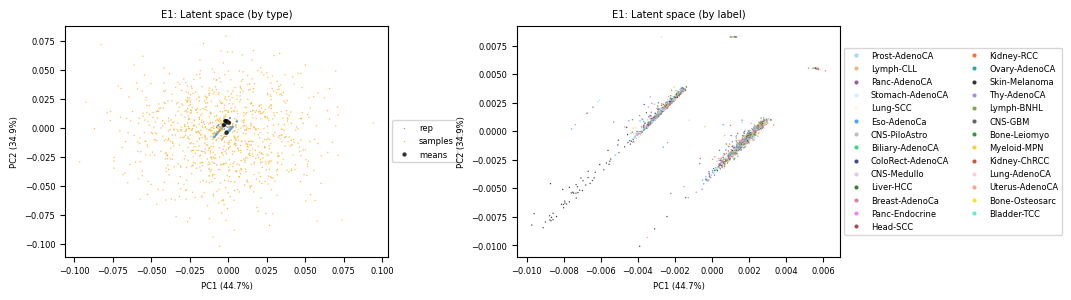

         PC1       PC2   type  label
0   0.068656  0.029662    rep  [C>A]
1  -0.004793  0.008045    rep  [C>A]
2  -0.013290 -0.011760    rep  [C>A]
3  -0.009141 -0.001383    rep  [C>A]
4   0.069618  0.021687    rep  [C>A]
..       ...       ...    ...    ...
1   0.002875  0.002217  means    NaN
2   0.007664  0.003905  means    NaN
3   0.008040  0.004207  means    NaN
4   0.008476  0.003536  means    NaN
5   0.007416  0.003925  means    NaN

[2542 rows x 4 columns]


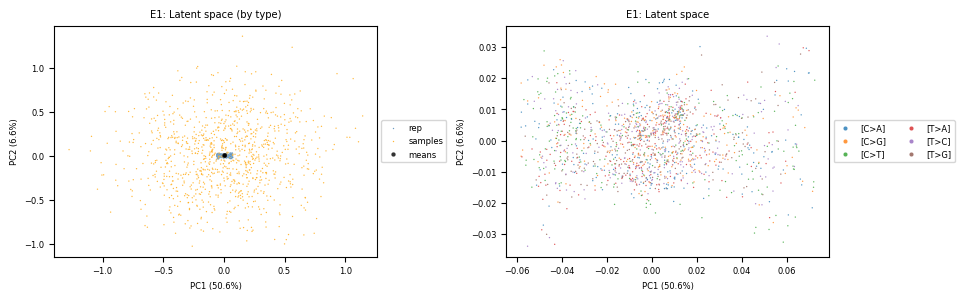

In [48]:
# train for x epochs and plot learning curves
n_epochs = 2
pr = 2 # how often to print loss
plot = 2

loss_tab = train_dgd(
    dgd, train_data, validation_loader, device,
    learning_rates={'dec':0.0001,'rep':0.01,'gmm':0.01},
    weight_decay=0.001,nepochs=n_epochs,pr=pr,plot=plot,reduction_type=reduction_type
    )

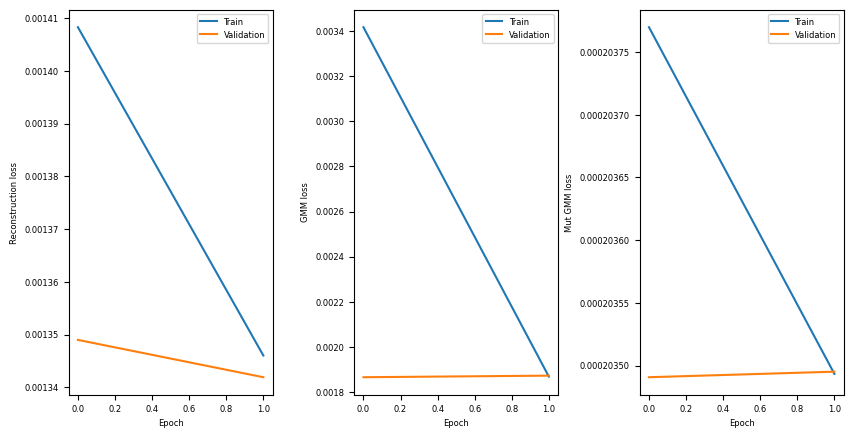

In [56]:
# make 2 subplots with recon and gmm loss curves
plt.figure(figsize=(10,5))
plt.subplot(1,3,1)
plt.plot(loss_tab["Epoch"],loss_tab["Train recon"],label="Train")
plt.plot(loss_tab["Epoch"],loss_tab["Test recon"],label="Validation")
plt.xlabel("Epoch")
plt.ylabel("Reconstruction loss")
plt.legend()
plt.subplot(1,3,2)
plt.plot(loss_tab["Epoch"],loss_tab["GMM train"],label="Train")
plt.plot(loss_tab["Epoch"],loss_tab["GMM test"],label="Validation")
plt.xlabel("Epoch")
plt.ylabel("GMM loss")
plt.legend()

# added
plt.subplot(1,3,3)
plt.plot(loss_tab["Epoch"],loss_tab["Mut GMM train"],label="Train")
plt.plot(loss_tab["Epoch"],loss_tab["Mut GMM test"],label="Validation")
plt.xlabel("Epoch")
plt.ylabel("Mut GMM loss")
plt.legend()

plt.subplots_adjust(wspace=0.4)

plt.savefig(f"learning_curves.pdf")

plt.show()

In [50]:
dgd

DGD(
  (decoder): Decoder(
    (main): ModuleList(
      (0): Linear(in_features=64, out_features=100, bias=True)
      (1): ReLU()
      (2): Linear(in_features=100, out_features=100, bias=True)
      (3): ReLU()
      (4): Linear(in_features=100, out_features=100, bias=True)
      (5): ReLU()
    )
    (out_modules): ModuleList(
      (0): NB_Module(
        (fc): Sequential(
          (0): Linear(in_features=100, out_features=1, bias=True)
        )
      )
    )
  )
  (gmm): GaussianMixture()
  (mut_gmm): GaussianMixture()
  (train_rep): RepresentationLayer()
  (val_rep): RepresentationLayer()
  (mut_train_rep): RepresentationLayer()
  (mut_val_rep): RepresentationLayer()
)

In [51]:
# save the trained model
torch.save(dgd, "mut_dgd_model_1.pth")

# Test representation

In [52]:
#dgd_model = torch.load("mut_dgd_model_1.pth", map_location=torch.device('cpu'))

In [53]:
dgd_model = torch.load("first_mut_dgd_model_1.pth")

/tmp/62371408/ipykernel_110051/4012902581.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  dgd_model = torch.load("first_mut_dgd_model_1.pth")


In [54]:
dgd_model

DGD(
  (decoder): Decoder(
    (main): ModuleList(
      (0): Linear(in_features=64, out_features=100, bias=True)
      (1): ReLU()
      (2): Linear(in_features=100, out_features=100, bias=True)
      (3): ReLU()
      (4): Linear(in_features=100, out_features=100, bias=True)
      (5): ReLU()
    )
    (out_modules): ModuleList(
      (0): NB_Module(
        (fc): Sequential(
          (0): Linear(in_features=100, out_features=1, bias=True)
        )
      )
    )
  )
  (gmm): GaussianMixture()
  (mut_gmm): GaussianMixture()
  (train_rep): RepresentationLayer()
  (val_rep): RepresentationLayer()
  (mut_train_rep): RepresentationLayer()
  (mut_val_rep): RepresentationLayer()
)

In [55]:
# take test part of mut_data
#test_data = mut_data.loc[X_test.index]
test_data

,AA[C>A]AA,AA[C>A]AC,AA[C>A]AG,AA[C>A]AT,AA[C>A]CA,AA[C>A]CC,AA[C>A]CG,AA[C>A]CT,AA[C>A]GA,AA[C>A]GC,...,TT[T>G]CT,TT[T>G]GA,TT[T>G]GC,TT[T>G]GG,TT[T>G]GT,TT[T>G]TA,TT[T>G]TC,TT[T>G]TG,TT[T>G]TT,Tumor_Type
Donor_ID,,,,,,,,,,,,,,,,,,,,,
DO51074,14,3,4,5,8,6,0,5,0,0,...,3,0,1,2,0,0,2,0,8,Prost-AdenoCA
DO51496,14,3,8,11,11,5,0,7,1,1,...,2,2,0,1,1,2,2,2,9,Panc-AdenoCA
DO15046,81,38,65,75,49,33,7,41,7,5,...,8,10,14,7,8,13,20,11,64,Head-SCC
DO6558,7,2,0,3,2,0,1,0,2,0,...,0,0,1,0,1,0,0,1,3,Lymph-CLL
DO50410,48,10,38,27,38,22,1,22,4,1,...,7,16,3,8,7,171,92,78,143,Eso-AdenoCa
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
DO46400,42,18,21,19,31,15,4,32,4,2,...,2,10,6,13,6,7,2,8,18,Ovary-AdenoCA
DO51514,13,8,11,10,7,10,0,7,1,0,...,0,3,0,8,4,9,6,8,25,Panc-AdenoCA
DO51144,16,2,6,3,10,4,0,8,0,0,...,0,2,0,0,0,2,3,1,10,Prost-AdenoCA


In [56]:
test_loader = torch.utils.data.DataLoader(FlattenedDataset(test_data, scaling_type="mean"), # default is scaling_type='mean'
                                          batch_size=1536,
                                          shuffle=False)

In [57]:
# Access the first sample (idx=0)
#mutations, lib, idx = see_test[0] 

# Print the results
#print("Mutations:", mutations)
#print("Library Size (lib):", lib)
#print("Index:", idx)

In [58]:
test_loader.dataset

Should have 100 gaussians for the mut type representation and 27 for the sample reps.
40 latent dimensions in total, 20 for each rep type.

In [59]:
# 8 min
new_rep = learn_new_representation(dgd_model, 
                             train_loader,
                             test_loader,
                             test_epochs=50,
                             learning_rates=1e-2,
                             weight_decay=0.,
                             betas=(0.5, 0.7),
                             reduction_type="mean",
                             resampling_type="mean")

torch.Size([374, 20])
Expected shape: (374, 20)
value_init shape: torch.Size([374, 20])


100%|███████████████████████████████████████████| 50/50 [12:19<00:00, 14.80s/it]


In [60]:
new_rep

RepresentationLayer()

In [61]:
dgd_model.train_rep

RepresentationLayer()

In [62]:
# assign the test representation from the predict function to the test_rep in the dgd model
dgd_model.test_rep = new_rep

In [63]:
dgd_test = dgd_model.get_representations(type="test")
dgd_test

array([[ 0.05514407,  0.04920964, -0.05213816, ...,  0.02073466,
         0.04467357, -0.01130086],
       [ 0.05080753,  0.0493004 , -0.04933042, ...,  0.02052635,
         0.04757786, -0.00753   ],
       [ 0.05096032,  0.05238291, -0.05159273, ...,  0.02370489,
         0.04663788, -0.00557951],
       ...,
       [ 0.05249821,  0.05307906, -0.0502942 , ...,  0.0250187 ,
         0.04820637, -0.00888475],
       [ 0.04685904,  0.05359345, -0.0510995 , ...,  0.02440215,
         0.04498222, -0.0118742 ],
       [ 0.05331384,  0.05132297, -0.05038793, ...,  0.02292188,
         0.0451056 , -0.01314843]], dtype=float32)

In [64]:
dgd_test.shape

(374, 20)

In [65]:
# make df with latent variable column names
dgd_test_df = pd.DataFrame(dgd_test, columns = ['L1', 'L2', 'L3', 'L4', 'L5', 'L6', 'L7', 'L8', 'L9', 'L10', 'L11', 'L12', 'L13', 'L14', 'L15', 'L16', 'L17', 'L18', 'L19', 'L20'])
dgd_test_df

,L1,L2,L3,L4,L5,L6,L7,L8,L9,L10,L11,L12,L13,L14,L15,L16,L17,L18,L19,L20
0,0.055144,0.049210,-0.052138,0.000950,0.025109,-0.023778,0.042472,-0.050734,-0.051228,0.035582,-0.051957,-0.002354,0.034384,-0.028587,0.000792,-0.050930,-0.007513,0.020735,0.044674,-0.011301
1,0.050808,0.049300,-0.049330,0.003988,0.028753,-0.025893,0.042252,-0.049804,-0.053778,0.035542,-0.051915,0.001477,0.032697,-0.027702,0.004227,-0.050203,-0.010114,0.020526,0.047578,-0.007530
2,0.050960,0.052383,-0.051593,0.001352,0.025665,-0.023013,0.040962,-0.052628,-0.051055,0.033113,-0.051942,-0.002140,0.030625,-0.025939,0.002117,-0.049336,-0.010082,0.023705,0.046638,-0.005580
3,0.050553,0.055300,-0.051218,0.003148,0.027031,-0.023366,0.045819,-0.054117,-0.053249,0.036166,-0.050321,-0.002926,0.031792,-0.027557,0.003676,-0.051251,-0.007062,0.021506,0.047189,-0.011077
4,0.049581,0.053542,-0.050006,-0.007157,0.025975,-0.022074,0.040065,-0.053877,-0.054329,0.033530,-0.051917,0.000628,0.031166,-0.027534,-0.006240,-0.054503,-0.010339,0.023391,0.044273,-0.009774
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
369,0.050986,0.049842,-0.050367,0.003393,0.026957,-0.022750,0.039242,-0.050491,-0.053904,0.033471,-0.051395,-0.004184,0.033188,-0.028474,0.003440,-0.052674,-0.008131,0.021101,0.048462,-0.011713
370,0.054804,0.048820,-0.050027,0.003044,0.030107,-0.024450,0.045687,-0.048626,-0.049329,0.038075,-0.050521,-0.003519,0.030977,-0.026839,0.002952,-0.048594,-0.005478,0.021738,0.044315,-0.012484
371,0.052498,0.053079,-0.050294,-0.000897,0.026973,-0.020977,0.039420,-0.053830,-0.051009,0.032481,-0.054043,0.000253,0.029239,-0.025510,-0.000859,-0.053789,-0.009615,0.025019,0.048206,-0.008885
372,0.046859,0.053593,-0.051100,-0.003257,0.025667,-0.026576,0.038246,-0.054143,-0.053869,0.032817,-0.056597,-0.004142,0.029201,-0.025808,-0.003800,-0.054252,-0.006075,0.024402,0.044982,-0.011874


In [66]:
test_data['Tumor_Type']

Donor_ID
DO51074    Prost-AdenoCA
DO51496     Panc-AdenoCA
DO15046         Head-SCC
DO6558         Lymph-CLL
DO50410      Eso-AdenoCa
               ...      
DO46400    Ovary-AdenoCA
DO51514     Panc-AdenoCA
DO51144    Prost-AdenoCA
DO23551        Liver-HCC
DO31420    Ovary-AdenoCA
Name: Tumor_Type, Length: 374, dtype: object

In [67]:
# add Donor_ID again
dgd_test_df.index = test_data.index
dgd_test_df

,L1,L2,L3,L4,L5,L6,L7,L8,L9,L10,L11,L12,L13,L14,L15,L16,L17,L18,L19,L20
Donor_ID,,,,,,,,,,,,,,,,,,,,
DO51074,0.055144,0.049210,-0.052138,0.000950,0.025109,-0.023778,0.042472,-0.050734,-0.051228,0.035582,-0.051957,-0.002354,0.034384,-0.028587,0.000792,-0.050930,-0.007513,0.020735,0.044674,-0.011301
DO51496,0.050808,0.049300,-0.049330,0.003988,0.028753,-0.025893,0.042252,-0.049804,-0.053778,0.035542,-0.051915,0.001477,0.032697,-0.027702,0.004227,-0.050203,-0.010114,0.020526,0.047578,-0.007530
DO15046,0.050960,0.052383,-0.051593,0.001352,0.025665,-0.023013,0.040962,-0.052628,-0.051055,0.033113,-0.051942,-0.002140,0.030625,-0.025939,0.002117,-0.049336,-0.010082,0.023705,0.046638,-0.005580
DO6558,0.050553,0.055300,-0.051218,0.003148,0.027031,-0.023366,0.045819,-0.054117,-0.053249,0.036166,-0.050321,-0.002926,0.031792,-0.027557,0.003676,-0.051251,-0.007062,0.021506,0.047189,-0.011077
DO50410,0.049581,0.053542,-0.050006,-0.007157,0.025975,-0.022074,0.040065,-0.053877,-0.054329,0.033530,-0.051917,0.000628,0.031166,-0.027534,-0.006240,-0.054503,-0.010339,0.023391,0.044273,-0.009774
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
DO46400,0.050986,0.049842,-0.050367,0.003393,0.026957,-0.022750,0.039242,-0.050491,-0.053904,0.033471,-0.051395,-0.004184,0.033188,-0.028474,0.003440,-0.052674,-0.008131,0.021101,0.048462,-0.011713
DO51514,0.054804,0.048820,-0.050027,0.003044,0.030107,-0.024450,0.045687,-0.048626,-0.049329,0.038075,-0.050521,-0.003519,0.030977,-0.026839,0.002952,-0.048594,-0.005478,0.021738,0.044315,-0.012484
DO51144,0.052498,0.053079,-0.050294,-0.000897,0.026973,-0.020977,0.039420,-0.053830,-0.051009,0.032481,-0.054043,0.000253,0.029239,-0.025510,-0.000859,-0.053789,-0.009615,0.025019,0.048206,-0.008885


In [68]:
# add tumor type, the sample order is preserved
dgd_test_df['Tumor_Type'] = test_data['Tumor_Type']
dgd_test_df

,L1,L2,L3,L4,L5,L6,L7,L8,L9,L10,...,L12,L13,L14,L15,L16,L17,L18,L19,L20,Tumor_Type
Donor_ID,,,,,,,,,,,,,,,,,,,,,
DO51074,0.055144,0.049210,-0.052138,0.000950,0.025109,-0.023778,0.042472,-0.050734,-0.051228,0.035582,...,-0.002354,0.034384,-0.028587,0.000792,-0.050930,-0.007513,0.020735,0.044674,-0.011301,Prost-AdenoCA
DO51496,0.050808,0.049300,-0.049330,0.003988,0.028753,-0.025893,0.042252,-0.049804,-0.053778,0.035542,...,0.001477,0.032697,-0.027702,0.004227,-0.050203,-0.010114,0.020526,0.047578,-0.007530,Panc-AdenoCA
DO15046,0.050960,0.052383,-0.051593,0.001352,0.025665,-0.023013,0.040962,-0.052628,-0.051055,0.033113,...,-0.002140,0.030625,-0.025939,0.002117,-0.049336,-0.010082,0.023705,0.046638,-0.005580,Head-SCC
DO6558,0.050553,0.055300,-0.051218,0.003148,0.027031,-0.023366,0.045819,-0.054117,-0.053249,0.036166,...,-0.002926,0.031792,-0.027557,0.003676,-0.051251,-0.007062,0.021506,0.047189,-0.011077,Lymph-CLL
DO50410,0.049581,0.053542,-0.050006,-0.007157,0.025975,-0.022074,0.040065,-0.053877,-0.054329,0.033530,...,0.000628,0.031166,-0.027534,-0.006240,-0.054503,-0.010339,0.023391,0.044273,-0.009774,Eso-AdenoCa
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
DO46400,0.050986,0.049842,-0.050367,0.003393,0.026957,-0.022750,0.039242,-0.050491,-0.053904,0.033471,...,-0.004184,0.033188,-0.028474,0.003440,-0.052674,-0.008131,0.021101,0.048462,-0.011713,Ovary-AdenoCA
DO51514,0.054804,0.048820,-0.050027,0.003044,0.030107,-0.024450,0.045687,-0.048626,-0.049329,0.038075,...,-0.003519,0.030977,-0.026839,0.002952,-0.048594,-0.005478,0.021738,0.044315,-0.012484,Panc-AdenoCA
DO51144,0.052498,0.053079,-0.050294,-0.000897,0.026973,-0.020977,0.039420,-0.053830,-0.051009,0.032481,...,0.000253,0.029239,-0.025510,-0.000859,-0.053789,-0.009615,0.025019,0.048206,-0.008885,Prost-AdenoCA


In [69]:
# save test reps for KNN
dgd_test_df.to_csv('onehot_mut_dgd_test_df.tsv', sep='\t', index=True)

In [70]:
print(dgd_model.test_rep)


        RepresentationLayer:
            Dimensionality: 20
            Number of samples: 374
            Value initialization: custom
        


# Train/val sample rep df for KNN

In [71]:
# check the saved coordinates are the same, they are
dgd_train = dgd_model.get_representations(type="train")
dgd_train

array([[ 0.05291944,  0.05286967, -0.0524221 , ...,  0.0221853 ,
         0.04719578, -0.01221553],
       [ 0.05320838,  0.05300053, -0.05248748, ...,  0.02359712,
         0.04741181, -0.00863899],
       [ 0.05298048,  0.05290752, -0.05256086, ...,  0.02204299,
         0.04701157, -0.00875526],
       ...,
       [ 0.05289676,  0.05289404, -0.05253393, ...,  0.02377577,
         0.04701907, -0.01165058],
       [ 0.05284851,  0.05289681, -0.05254905, ...,  0.02309648,
         0.04747404, -0.00867174],
       [ 0.05306276,  0.05298444, -0.05251654, ...,  0.02230528,
         0.04727377, -0.01142227]], dtype=float32)

In [72]:
type(dgd_train)

numpy.ndarray

In [73]:
dgd_train.shape

(1744, 20)

In [74]:
# make df with latent variable column names
dgd_train_df = pd.DataFrame(dgd_train, columns=['L1', 'L2', 'L3', 'L4', 'L5', 'L6', 'L7', 'L8', 'L9', 'L10', 'L11', 'L12', 'L13', 'L14', 'L15', 'L16', 'L17', 'L18', 'L19', 'L20'])
dgd_train_df

,L1,L2,L3,L4,L5,L6,L7,L8,L9,L10,L11,L12,L13,L14,L15,L16,L17,L18,L19,L20
0,0.052919,0.052870,-0.052422,0.000953,0.026304,-0.025530,0.042053,-0.052873,-0.052584,0.035890,-0.052790,0.001657,0.031501,-0.026624,0.000086,-0.052613,-0.007979,0.022185,0.047196,-0.012216
1,0.053208,0.053001,-0.052487,-0.002404,0.024801,-0.022416,0.042365,-0.052912,-0.053051,0.036294,-0.052953,-0.003376,0.030312,-0.026116,-0.004584,-0.053114,-0.005748,0.023597,0.047412,-0.008639
2,0.052980,0.052908,-0.052561,0.001493,0.027059,-0.022957,0.042285,-0.052927,-0.052824,0.035121,-0.052935,-0.000419,0.030817,-0.025267,-0.000583,-0.052927,-0.008549,0.022043,0.047012,-0.008755
3,0.052954,0.052916,-0.052546,-0.002195,0.024631,-0.023649,0.042924,-0.052904,-0.052670,0.036092,-0.052849,-0.001943,0.031336,-0.026011,0.003429,-0.052803,-0.009017,0.021854,0.047041,-0.012213
4,0.052931,0.052908,-0.052557,-0.001931,0.026118,-0.022693,0.042426,-0.052891,-0.052648,0.035537,-0.052821,-0.001684,0.031362,-0.026722,0.003519,-0.052799,-0.006100,0.022455,0.046637,-0.011854
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1739,0.052963,0.052992,-0.052437,-0.000838,0.027361,-0.024960,0.041532,-0.053082,-0.052568,0.035926,-0.052869,-0.004389,0.030663,-0.025864,-0.002642,-0.052636,-0.005684,0.021991,0.046824,-0.013886
1740,0.052975,0.052959,-0.052444,-0.003152,0.027084,-0.025142,0.042589,-0.053005,-0.052717,0.035564,-0.052874,-0.002816,0.030962,-0.026313,0.001842,-0.052771,-0.004932,0.023135,0.047000,-0.011949
1741,0.052897,0.052894,-0.052534,-0.001613,0.024324,-0.023359,0.042463,-0.052903,-0.052708,0.035547,-0.052857,-0.001011,0.031530,-0.025647,0.004028,-0.052807,-0.008847,0.023776,0.047019,-0.011651
1742,0.052849,0.052897,-0.052549,0.002410,0.027469,-0.025778,0.042981,-0.052942,-0.052548,0.036243,-0.052822,0.000453,0.029630,-0.028701,0.002223,-0.052558,-0.007202,0.023096,0.047474,-0.008672


In [75]:
# add Donor_ID again
dgd_train_df.index = train_data.index
dgd_train_df

,L1,L2,L3,L4,L5,L6,L7,L8,L9,L10,L11,L12,L13,L14,L15,L16,L17,L18,L19,L20
Donor_ID,,,,,,,,,,,,,,,,,,,,
DO50420,0.052919,0.052870,-0.052422,0.000953,0.026304,-0.025530,0.042053,-0.052873,-0.052584,0.035890,-0.052790,0.001657,0.031501,-0.026624,0.000086,-0.052613,-0.007979,0.022185,0.047196,-0.012216
DO52701,0.053208,0.053001,-0.052487,-0.002404,0.024801,-0.022416,0.042365,-0.052912,-0.053051,0.036294,-0.052953,-0.003376,0.030312,-0.026116,-0.004584,-0.053114,-0.005748,0.023597,0.047412,-0.008639
DO51500,0.052980,0.052908,-0.052561,0.001493,0.027059,-0.022957,0.042285,-0.052927,-0.052824,0.035121,-0.052935,-0.000419,0.030817,-0.025267,-0.000583,-0.052927,-0.008549,0.022043,0.047012,-0.008755
DO10829,0.052954,0.052916,-0.052546,-0.002195,0.024631,-0.023649,0.042924,-0.052904,-0.052670,0.036092,-0.052849,-0.001943,0.031336,-0.026011,0.003429,-0.052803,-0.009017,0.021854,0.047041,-0.012213
DO51069,0.052931,0.052908,-0.052557,-0.001931,0.026118,-0.022693,0.042426,-0.052891,-0.052648,0.035537,-0.052821,-0.001684,0.031362,-0.026722,0.003519,-0.052799,-0.006100,0.022455,0.046637,-0.011854
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
DO45239,0.052963,0.052992,-0.052437,-0.000838,0.027361,-0.024960,0.041532,-0.053082,-0.052568,0.035926,-0.052869,-0.004389,0.030663,-0.025864,-0.002642,-0.052636,-0.005684,0.021991,0.046824,-0.013886
DO6474,0.052975,0.052959,-0.052444,-0.003152,0.027084,-0.025142,0.042589,-0.053005,-0.052717,0.035564,-0.052874,-0.002816,0.030962,-0.026313,0.001842,-0.052771,-0.004932,0.023135,0.047000,-0.011949
DO48952,0.052897,0.052894,-0.052534,-0.001613,0.024324,-0.023359,0.042463,-0.052903,-0.052708,0.035547,-0.052857,-0.001011,0.031530,-0.025647,0.004028,-0.052807,-0.008847,0.023776,0.047019,-0.011651


In [76]:
# add tissue, the sample order is preserved
dgd_train_df['Tumor_Type'] = train_data['Tumor_Type']
dgd_train_df

,L1,L2,L3,L4,L5,L6,L7,L8,L9,L10,...,L12,L13,L14,L15,L16,L17,L18,L19,L20,Tumor_Type
Donor_ID,,,,,,,,,,,,,,,,,,,,,
DO50420,0.052919,0.052870,-0.052422,0.000953,0.026304,-0.025530,0.042053,-0.052873,-0.052584,0.035890,...,0.001657,0.031501,-0.026624,0.000086,-0.052613,-0.007979,0.022185,0.047196,-0.012216,Prost-AdenoCA
DO52701,0.053208,0.053001,-0.052487,-0.002404,0.024801,-0.022416,0.042365,-0.052912,-0.053051,0.036294,...,-0.003376,0.030312,-0.026116,-0.004584,-0.053114,-0.005748,0.023597,0.047412,-0.008639,Lymph-CLL
DO51500,0.052980,0.052908,-0.052561,0.001493,0.027059,-0.022957,0.042285,-0.052927,-0.052824,0.035121,...,-0.000419,0.030817,-0.025267,-0.000583,-0.052927,-0.008549,0.022043,0.047012,-0.008755,Panc-AdenoCA
DO10829,0.052954,0.052916,-0.052546,-0.002195,0.024631,-0.023649,0.042924,-0.052904,-0.052670,0.036092,...,-0.001943,0.031336,-0.026011,0.003429,-0.052803,-0.009017,0.021854,0.047041,-0.012213,Prost-AdenoCA
DO51069,0.052931,0.052908,-0.052557,-0.001931,0.026118,-0.022693,0.042426,-0.052891,-0.052648,0.035537,...,-0.001684,0.031362,-0.026722,0.003519,-0.052799,-0.006100,0.022455,0.046637,-0.011854,Prost-AdenoCA
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
DO45239,0.052963,0.052992,-0.052437,-0.000838,0.027361,-0.024960,0.041532,-0.053082,-0.052568,0.035926,...,-0.004389,0.030663,-0.025864,-0.002642,-0.052636,-0.005684,0.021991,0.046824,-0.013886,Liver-HCC
DO6474,0.052975,0.052959,-0.052444,-0.003152,0.027084,-0.025142,0.042589,-0.053005,-0.052717,0.035564,...,-0.002816,0.030962,-0.026313,0.001842,-0.052771,-0.004932,0.023135,0.047000,-0.011949,Lymph-CLL
DO48952,0.052897,0.052894,-0.052534,-0.001613,0.024324,-0.023359,0.042463,-0.052903,-0.052708,0.035547,...,-0.001011,0.031530,-0.025647,0.004028,-0.052807,-0.008847,0.023776,0.047019,-0.011651,CNS-Medullo


Validation set

In [77]:
# DGD coordinates for validation data
dgd_val = dgd_model.get_representations(type="val")
dgd_val

array([[ 0.05074658,  0.04714514, -0.0538549 , ...,  0.01837104,
         0.04759869, -0.0126402 ],
       [ 0.04708036,  0.05576123, -0.05386993, ...,  0.0258525 ,
         0.04754041, -0.01086261],
       [ 0.04738944,  0.0469565 , -0.04675447, ...,  0.02651365,
         0.04065787, -0.0157567 ],
       ...,
       [ 0.05462793,  0.04707595, -0.04674779, ...,  0.0183645 ,
         0.04091106, -0.01398176],
       [ 0.05496346,  0.04708849, -0.04651235, ...,  0.01855102,
         0.04133556, -0.01650795],
       [ 0.05190389,  0.0471488 , -0.04676659, ...,  0.01844233,
         0.04712673, -0.01319289]], dtype=float32)

In [78]:
dgd_val_df = pd.DataFrame(dgd_val, columns=['L1', 'L2', 'L3', 'L4', 'L5', 'L6', 'L7', 'L8', 'L9', 'L10', 'L11', 'L12', 'L13', 'L14', 'L15', 'L16', 'L17', 'L18', 'L19', 'L20'])
dgd_val_df

,L1,L2,L3,L4,L5,L6,L7,L8,L9,L10,L11,L12,L13,L14,L15,L16,L17,L18,L19,L20
0,0.050747,0.047145,-0.053855,-0.000617,0.018946,-0.023204,0.035840,-0.053718,-0.051974,0.037022,-0.055698,-0.004711,0.024237,-0.027181,-0.000510,-0.046907,-0.010917,0.018371,0.047599,-0.012640
1,0.047080,0.055761,-0.053870,0.000039,0.026945,-0.017796,0.035727,-0.054083,-0.051554,0.028138,-0.047138,-0.004944,0.024528,-0.019803,0.001472,-0.055731,-0.008866,0.025852,0.047540,-0.010863
2,0.047389,0.046957,-0.046754,0.004512,0.027476,-0.017616,0.036109,-0.047443,-0.046806,0.037982,-0.046976,-0.005424,0.031702,-0.019921,0.003811,-0.055986,-0.009487,0.026514,0.040658,-0.015757
3,0.055032,0.047099,-0.046725,0.001307,0.028111,-0.023200,0.035935,-0.047791,-0.046963,0.037169,-0.047114,-0.004526,0.031825,-0.020127,0.000842,-0.046878,-0.010528,0.018358,0.040983,-0.014558
4,0.055987,0.047206,-0.046737,-0.002421,0.019138,-0.023123,0.036159,-0.047695,-0.046766,0.038494,-0.046955,-0.003899,0.031626,-0.026930,-0.002726,-0.046843,-0.011456,0.018809,0.041105,-0.011994
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
369,0.047451,0.047121,-0.046782,-0.001159,0.029323,-0.017949,0.036065,-0.047678,-0.046865,0.038246,-0.046996,-0.004888,0.031595,-0.020103,-0.002071,-0.055859,-0.011212,0.018704,0.040942,-0.012625
370,0.056200,0.047156,-0.054119,-0.000706,0.019066,-0.018410,0.036053,-0.047891,-0.046951,0.038788,-0.047069,-0.007126,0.024091,-0.020335,-0.004437,-0.046794,-0.008961,0.018650,0.041314,-0.016283
371,0.054628,0.047076,-0.046748,0.002579,0.028719,-0.018053,0.035910,-0.047765,-0.046949,0.036247,-0.055692,-0.004125,0.024280,-0.029205,0.002950,-0.046879,-0.011073,0.018365,0.040911,-0.013982
372,0.054963,0.047088,-0.046512,-0.007146,0.026623,-0.021116,0.036221,-0.047691,-0.046732,0.036300,-0.046943,0.000294,0.033257,-0.025181,-0.005335,-0.046714,-0.004850,0.018551,0.041336,-0.016508


In [79]:
# add original index
dgd_val_df.index = validation_data.index
dgd_val_df

,L1,L2,L3,L4,L5,L6,L7,L8,L9,L10,L11,L12,L13,L14,L15,L16,L17,L18,L19,L20
Donor_ID,,,,,,,,,,,,,,,,,,,,
DO50837,0.050747,0.047145,-0.053855,-0.000617,0.018946,-0.023204,0.035840,-0.053718,-0.051974,0.037022,-0.055698,-0.004711,0.024237,-0.027181,-0.000510,-0.046907,-0.010917,0.018371,0.047599,-0.012640
DO9074,0.047080,0.055761,-0.053870,0.000039,0.026945,-0.017796,0.035727,-0.054083,-0.051554,0.028138,-0.047138,-0.004944,0.024528,-0.019803,0.001472,-0.055731,-0.008866,0.025852,0.047540,-0.010863
DO15398,0.047389,0.046957,-0.046754,0.004512,0.027476,-0.017616,0.036109,-0.047443,-0.046806,0.037982,-0.046976,-0.005424,0.031702,-0.019921,0.003811,-0.055986,-0.009487,0.026514,0.040658,-0.015757
DO46744,0.055032,0.047099,-0.046725,0.001307,0.028111,-0.023200,0.035935,-0.047791,-0.046963,0.037169,-0.047114,-0.004526,0.031825,-0.020127,0.000842,-0.046878,-0.010528,0.018358,0.040983,-0.014558
DO49768,0.055987,0.047206,-0.046737,-0.002421,0.019138,-0.023123,0.036159,-0.047695,-0.046766,0.038494,-0.046955,-0.003899,0.031626,-0.026930,-0.002726,-0.046843,-0.011456,0.018809,0.041105,-0.011994
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
DO46328,0.047451,0.047121,-0.046782,-0.001159,0.029323,-0.017949,0.036065,-0.047678,-0.046865,0.038246,-0.046996,-0.004888,0.031595,-0.020103,-0.002071,-0.055859,-0.011212,0.018704,0.040942,-0.012625
DO23028,0.056200,0.047156,-0.054119,-0.000706,0.019066,-0.018410,0.036053,-0.047891,-0.046951,0.038788,-0.047069,-0.007126,0.024091,-0.020335,-0.004437,-0.046794,-0.008961,0.018650,0.041314,-0.016283
DO48925,0.054628,0.047076,-0.046748,0.002579,0.028719,-0.018053,0.035910,-0.047765,-0.046949,0.036247,-0.055692,-0.004125,0.024280,-0.029205,0.002950,-0.046879,-0.011073,0.018365,0.040911,-0.013982


In [80]:
dgd_val_df['Tumor_Type'] = validation_data['Tumor_Type']
dgd_val_df

,L1,L2,L3,L4,L5,L6,L7,L8,L9,L10,...,L12,L13,L14,L15,L16,L17,L18,L19,L20,Tumor_Type
Donor_ID,,,,,,,,,,,,,,,,,,,,,
DO50837,0.050747,0.047145,-0.053855,-0.000617,0.018946,-0.023204,0.035840,-0.053718,-0.051974,0.037022,...,-0.004711,0.024237,-0.027181,-0.000510,-0.046907,-0.010917,0.018371,0.047599,-0.012640,Liver-HCC
DO9074,0.047080,0.055761,-0.053870,0.000039,0.026945,-0.017796,0.035727,-0.054083,-0.051554,0.028138,...,-0.004944,0.024528,-0.019803,0.001472,-0.055731,-0.008866,0.025852,0.047540,-0.010863,ColoRect-AdenoCA
DO15398,0.047389,0.046957,-0.046754,0.004512,0.027476,-0.017616,0.036109,-0.047443,-0.046806,0.037982,...,-0.005424,0.031702,-0.019921,0.003811,-0.055986,-0.009487,0.026514,0.040658,-0.015757,Head-SCC
DO46744,0.055032,0.047099,-0.046725,0.001307,0.028111,-0.023200,0.035935,-0.047791,-0.046963,0.037169,...,-0.004526,0.031825,-0.020127,0.000842,-0.046878,-0.010528,0.018358,0.040983,-0.014558,Panc-Endocrine
DO49768,0.055987,0.047206,-0.046737,-0.002421,0.019138,-0.023123,0.036159,-0.047695,-0.046766,0.038494,...,-0.003899,0.031626,-0.026930,-0.002726,-0.046843,-0.011456,0.018809,0.041105,-0.011994,Kidney-RCC
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
DO46328,0.047451,0.047121,-0.046782,-0.001159,0.029323,-0.017949,0.036065,-0.047678,-0.046865,0.038246,...,-0.004888,0.031595,-0.020103,-0.002071,-0.055859,-0.011212,0.018704,0.040942,-0.012625,Ovary-AdenoCA
DO23028,0.056200,0.047156,-0.054119,-0.000706,0.019066,-0.018410,0.036053,-0.047891,-0.046951,0.038788,...,-0.007126,0.024091,-0.020335,-0.004437,-0.046794,-0.008961,0.018650,0.041314,-0.016283,Liver-HCC
DO48925,0.054628,0.047076,-0.046748,0.002579,0.028719,-0.018053,0.035910,-0.047765,-0.046949,0.036247,...,-0.004125,0.024280,-0.029205,0.002950,-0.046879,-0.011073,0.018365,0.040911,-0.013982,CNS-Medullo


In [81]:
# merge and sort dfs
concat = pd.concat([dgd_train_df, dgd_val_df], axis=0)
concat

,L1,L2,L3,L4,L5,L6,L7,L8,L9,L10,...,L12,L13,L14,L15,L16,L17,L18,L19,L20,Tumor_Type
Donor_ID,,,,,,,,,,,,,,,,,,,,,
DO50420,0.052919,0.052870,-0.052422,0.000953,0.026304,-0.025530,0.042053,-0.052873,-0.052584,0.035890,...,0.001657,0.031501,-0.026624,0.000086,-0.052613,-0.007979,0.022185,0.047196,-0.012216,Prost-AdenoCA
DO52701,0.053208,0.053001,-0.052487,-0.002404,0.024801,-0.022416,0.042365,-0.052912,-0.053051,0.036294,...,-0.003376,0.030312,-0.026116,-0.004584,-0.053114,-0.005748,0.023597,0.047412,-0.008639,Lymph-CLL
DO51500,0.052980,0.052908,-0.052561,0.001493,0.027059,-0.022957,0.042285,-0.052927,-0.052824,0.035121,...,-0.000419,0.030817,-0.025267,-0.000583,-0.052927,-0.008549,0.022043,0.047012,-0.008755,Panc-AdenoCA
DO10829,0.052954,0.052916,-0.052546,-0.002195,0.024631,-0.023649,0.042924,-0.052904,-0.052670,0.036092,...,-0.001943,0.031336,-0.026011,0.003429,-0.052803,-0.009017,0.021854,0.047041,-0.012213,Prost-AdenoCA
DO51069,0.052931,0.052908,-0.052557,-0.001931,0.026118,-0.022693,0.042426,-0.052891,-0.052648,0.035537,...,-0.001684,0.031362,-0.026722,0.003519,-0.052799,-0.006100,0.022455,0.046637,-0.011854,Prost-AdenoCA
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
DO46328,0.047451,0.047121,-0.046782,-0.001159,0.029323,-0.017949,0.036065,-0.047678,-0.046865,0.038246,...,-0.004888,0.031595,-0.020103,-0.002071,-0.055859,-0.011212,0.018704,0.040942,-0.012625,Ovary-AdenoCA
DO23028,0.056200,0.047156,-0.054119,-0.000706,0.019066,-0.018410,0.036053,-0.047891,-0.046951,0.038788,...,-0.007126,0.024091,-0.020335,-0.004437,-0.046794,-0.008961,0.018650,0.041314,-0.016283,Liver-HCC
DO48925,0.054628,0.047076,-0.046748,0.002579,0.028719,-0.018053,0.035910,-0.047765,-0.046949,0.036247,...,-0.004125,0.024280,-0.029205,0.002950,-0.046879,-0.011073,0.018365,0.040911,-0.013982,CNS-Medullo


In [82]:
merged_df = concat.sort_index(axis=0)
merged_df

,L1,L2,L3,L4,L5,L6,L7,L8,L9,L10,...,L12,L13,L14,L15,L16,L17,L18,L19,L20,Tumor_Type
Donor_ID,,,,,,,,,,,,,,,,,,,,,
DO1001,0.052964,0.052856,-0.052513,0.001658,0.025789,-0.025223,0.042435,-0.052677,-0.052124,0.034489,...,-0.006033,0.030678,-0.027954,0.000428,-0.052564,-0.005617,0.022877,0.046248,-0.012523,Breast-AdenoCa
DO1002,0.052906,0.052906,-0.052485,-0.000664,0.025219,-0.024753,0.041211,-0.052846,-0.052749,0.033834,...,-0.005785,0.031425,-0.025346,0.004197,-0.052918,-0.007264,0.022173,0.046215,-0.010614,Breast-AdenoCa
DO1003,0.052995,0.052916,-0.052604,0.001520,0.027143,-0.022881,0.041788,-0.052841,-0.052339,0.034575,...,-0.003090,0.030568,-0.025911,-0.001030,-0.052766,-0.005193,0.022579,0.046141,-0.011932,Breast-AdenoCa
DO1004,0.052977,0.052936,-0.052488,0.001302,0.025712,-0.024315,0.041839,-0.052839,-0.052285,0.033851,...,-0.006792,0.030727,-0.026150,-0.000723,-0.052632,-0.006392,0.024063,0.045604,-0.012720,Breast-AdenoCa
DO1005,0.052761,0.052792,-0.052487,0.003447,0.026165,-0.025470,0.041397,-0.052715,-0.052303,0.035911,...,-0.005192,0.029810,-0.027914,0.002144,-0.052576,-0.006322,0.024995,0.046364,-0.013413,Breast-AdenoCa
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
DO9106,0.047284,0.055722,-0.053978,-0.000937,0.027057,-0.017863,0.035899,-0.053994,-0.051361,0.028283,...,-0.002795,0.024357,-0.019948,-0.000285,-0.055421,-0.008110,0.026916,0.047551,-0.009030,ColoRect-AdenoCA
DO9700,0.053049,0.052859,-0.052699,0.001211,0.024407,-0.024076,0.041593,-0.052656,-0.053123,0.034476,...,-0.000194,0.030579,-0.025699,0.000296,-0.053076,-0.009182,0.023884,0.046177,-0.010042,ColoRect-AdenoCA
DO9732,0.053010,0.052848,-0.052723,-0.000289,0.025619,-0.023674,0.043481,-0.052705,-0.052364,0.036617,...,-0.002646,0.031420,-0.027568,0.002116,-0.052540,-0.007388,0.021898,0.047335,-0.012487,ColoRect-AdenoCA


In [83]:
# save df for KNN
merged_df.to_csv('onehot_mut_dgd_df.tsv', sep='\t', index=True)

In [84]:
# reload
merged_df = pd.read_csv('dgd_df.tsv', sep='\t')
merged_df

,Donor_ID,L1,L2,L3,L4,L5,L6,L7,L8,L9,...,L12,L13,L14,L15,L16,L17,L18,L19,L20,Tumor_Type
0,DO1001,-0.059443,0.059307,0.006666,0.059429,0.059121,0.058519,-0.059345,-0.003948,0.007083,...,0.059071,0.059254,0.004150,0.058520,0.059228,0.059144,-0.059394,-0.059441,0.023936,Breast-AdenoCa
1,DO1002,-0.059278,0.059376,0.005732,0.059457,0.058883,0.058640,-0.059390,-0.001226,0.008013,...,0.059329,0.059506,0.004231,0.058660,0.059290,0.059500,-0.059202,-0.059336,0.023722,Breast-AdenoCa
2,DO1003,-0.059399,0.059325,0.005918,0.059423,0.059162,0.058813,-0.059365,-0.002800,0.007055,...,0.059018,0.059312,0.004882,0.058718,0.059262,0.059218,-0.059355,-0.059385,0.023785,Breast-AdenoCa
3,DO1004,-0.059329,0.059373,0.005090,0.059525,0.058951,0.058634,-0.059371,-0.002795,0.008695,...,0.059018,0.059449,0.002948,0.058426,0.059283,0.059105,-0.059267,-0.059342,0.024158,Breast-AdenoCa
4,DO1005,-0.059376,0.059283,0.009196,0.059449,0.059176,0.058615,-0.059317,0.000309,0.005873,...,0.059073,0.059291,0.005836,0.058725,0.059211,0.059272,-0.059335,-0.059536,0.024358,Breast-AdenoCa
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2113,DO9106,-0.058371,0.059222,0.003610,0.058098,0.058313,0.058652,-0.058431,0.002285,0.002053,...,0.058992,0.057910,-0.000418,0.059636,0.058043,0.057869,-0.060735,-0.060769,0.023476,ColoRect-AdenoCA
2114,DO9700,-0.059425,0.059304,0.002679,0.059467,0.058827,0.058092,-0.059395,-0.001892,0.004280,...,0.059207,0.059096,0.000257,0.058179,0.059144,0.058907,-0.059401,-0.059231,0.023943,ColoRect-AdenoCA
2115,DO9732,-0.059494,0.059450,0.003254,0.059719,0.059353,0.058584,-0.059182,-0.001831,0.005103,...,0.059139,0.058920,0.000782,0.058191,0.058976,0.058874,-0.059561,-0.059439,0.024244,ColoRect-AdenoCA
2116,DO9788,-0.059410,0.059373,0.001510,0.059395,0.058913,0.058352,-0.059315,-0.001684,0.002816,...,0.059209,0.059194,-0.000746,0.058548,0.059216,0.058898,-0.059472,-0.059370,0.024516,ColoRect-AdenoCA


In [85]:
# the tissue from mut_data in the same index order as the merged_df
mut_data = mut_data.sort_index()
mut_data

,AA[C>A]AA,AA[C>A]AC,AA[C>A]AG,AA[C>A]AT,AA[C>A]CA,AA[C>A]CC,AA[C>A]CG,AA[C>A]CT,AA[C>A]GA,AA[C>A]GC,...,TT[T>G]CT,TT[T>G]GA,TT[T>G]GC,TT[T>G]GG,TT[T>G]GT,TT[T>G]TA,TT[T>G]TC,TT[T>G]TG,TT[T>G]TT,Tumor_Type
Donor_ID,,,,,,,,,,,,,,,,,,,,,
DO1001,12,6,5,11,7,4,2,6,2,0,...,2,7,4,5,7,12,5,3,13,Breast-AdenoCa
DO1002,20,4,6,5,11,9,0,4,3,2,...,3,4,0,6,6,6,1,2,7,Breast-AdenoCa
DO1003,13,4,7,6,3,6,0,9,2,0,...,2,6,3,1,6,5,3,3,8,Breast-AdenoCa
DO1004,34,11,19,24,33,13,3,20,2,1,...,11,9,7,10,12,5,7,6,17,Breast-AdenoCa
DO1005,9,5,5,7,9,10,3,9,0,0,...,3,3,3,2,3,5,4,2,4,Breast-AdenoCa
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
DO9700,51,14,40,43,47,17,2,29,4,0,...,4,19,7,14,13,47,27,13,80,ColoRect-AdenoCA
DO9732,76,21,24,47,39,28,0,22,5,3,...,5,9,6,14,15,17,27,12,48,ColoRect-AdenoCA
DO9788,59,10,25,26,26,16,2,20,7,2,...,4,14,6,7,13,39,27,18,65,ColoRect-AdenoCA
